In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from glob import glob
from pprint import pprint
from collections import defaultdict
import gc
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf



In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/asmagamal2/ocular-diseases-asma?select=Eye-diseasesasma")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ghandor
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/asmagamal2/ocular-diseases-asma


100%|██████████| 2.16G/2.16G [01:41<00:00, 22.9MB/s]


In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohamedberrimi/oct-images-balanced-version/code")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ghandor
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mohamedberrimi/oct-images-balanced-version


100%|██████████| 4.15G/4.15G [03:15<00:00, 22.8MB/s]


Displaying 5 images from 'oct' class:


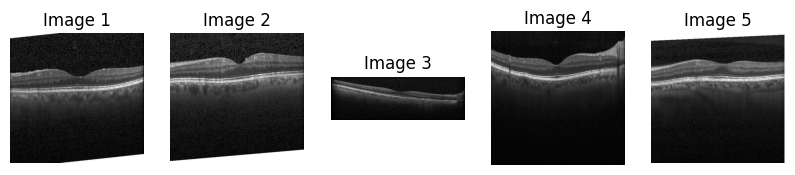

Displaying 5 images from 'cfp' class:


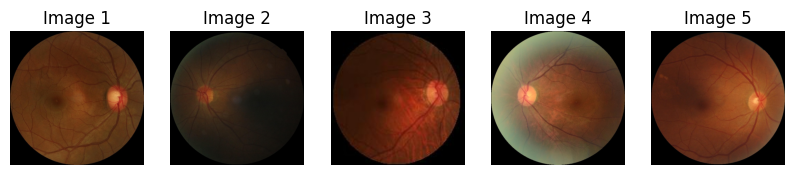

In [ ]:

import os
import shutil
import random
import matplotlib.pyplot as plt
import cv2


oct_path = '/content/oct-images-balanced-version/OCT_Balanced_Version/Balanced/NORMAL'
cfp_path = '/content/ocular-diseases-asma/Eye-diseasesasma/Normal'


new_base_path = '/content/oct-cfp-images'
os.makedirs(new_base_path, exist_ok=True)


oct_folder = os.path.join(new_base_path, 'oct')
cfp_folder = os.path.join(new_base_path, 'cfp')

os.makedirs(oct_folder, exist_ok=True)
os.makedirs(cfp_folder, exist_ok=True)


def copy_random_images(source_path, dest_path, num_images=3000):
    all_images = [f for f in os.listdir(source_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_images = random.sample(all_images, num_images)
    for image in selected_images:
        image_path = os.path.join(source_path, image)
        shutil.copy(image_path, dest_path)


copy_random_images(oct_path, oct_folder)
copy_random_images(cfp_path, cfp_folder)


def display_images_from_folder(folder_path, num_images=5):
    images = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_images = random.sample(images, num_images)
    plt.figure(figsize=(10, 10))

    for i, image_name in enumerate(selected_images):
        img_path = os.path.join(folder_path, image_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')

    plt.show()


print("Displaying 5 images from 'oct' class:")
display_images_from_folder(oct_folder)

print("Displaying 5 images from 'cfp' class:")
display_images_from_folder(cfp_folder)

In [ ]:

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models


data_dir = '/content/oct-cfp-images'


batch_size = 32
img_size = (224, 224)


train_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123
)


train_size = int(0.8 * len(train_val_ds))
test_size = len(train_val_ds) - train_size

train_ds = train_val_ds.take(train_size)
test_ds = train_val_ds.skip(train_size)


Found 6000 files belonging to 2 classes.
Using 4800 files for training.
Found 6000 files belonging to 2 classes.
Using 1200 files for validation.


In [ ]:


base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


base_model.trainable = False


model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

model.save('/content/oct_cfp_vgg19_model_optimized.h5')



from tensorflow.keras.models import load_model


loaded_model = load_model('/content/oct_cfp_vgg19_model_optimized.h5')


loaded_model.summary()




Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,447,682 (100.89 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 29s 216ms/step - accuracy: 0.9833 - loss: 0.2427 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 25s 210ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 29s 242ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 28s 237ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 29s 242ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,447,684 (100.89 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print(f"Final Training Accuracy: {train_accuracy[-1] * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy[-1] * 100:.2f}%")


Final Training Accuracy: 100.00%
Final Validation Accuracy: 100.00%


In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Accuracy: 100.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


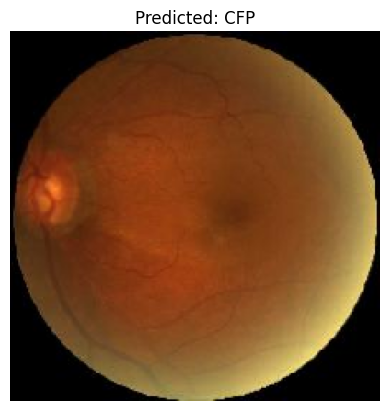

The model predicts this image as: CFP


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image


model = tf.keras.models.load_model('/content/oct_cfp_vgg19_model_optimized.h5')


class_names = ["CFP", "OCT"]

def predict_image(image_path):

    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    class_name = class_names[predicted_class]


    plt.imshow(img)
    plt.title(f"Predicted: {class_name}")
    plt.axis('off')
    plt.show()

    return class_name


image_path = "/content/glaucoma (6).jpg"
predicted_class = predict_image(image_path)
print(f"The model predicts this image as: {predicted_class}")
